<a href="https://colab.research.google.com/github/denn98987/yolovideo/blob/main/Training_Yolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Data load


In [1]:
!curl 'https://motchallenge.net/data/MOT20Det.zip' -H 'User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:86.0) Gecko/20100101 Firefox/86.0' -H 'Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8' -H 'Accept-Language: ru-RU,ru;q=0.8,en-US;q=0.5,en;q=0.3' --compressed -H 'Connection: keep-alive' -H 'Referer: https://motchallenge.net/data/MOT20Det/' -H 'Cookie: PHPSESSID=jljbeou0p3uqnubjv7h93c6uas' -H 'Upgrade-Insecure-Requests: 1' > 'data.zip'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4788M  100 4788M    0     0  12.7M      0  0:06:15  0:06:15 --:--:-- 15.0M


In [2]:
!unzip data.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: MOT20Det/train/MOT20-05/img1/001749.jpg  
  inflating: MOT20Det/train/MOT20-05/img1/002678.jpg  
  inflating: MOT20Det/train/MOT20-05/img1/000191.jpg  
  inflating: MOT20Det/train/MOT20-05/img1/003108.jpg  
  inflating: MOT20Det/train/MOT20-05/img1/001639.jpg  
  inflating: MOT20Det/train/MOT20-05/img1/001889.jpg  
  inflating: MOT20Det/train/MOT20-05/img1/001945.jpg  
  inflating: MOT20Det/train/MOT20-05/img1/000828.jpg  
  inflating: MOT20Det/train/MOT20-05/img1/001705.jpg  
  inflating: MOT20Det/train/MOT20-05/img1/001464.jpg  
  inflating: MOT20Det/train/MOT20-05/img1/000252.jpg  
  inflating: MOT20Det/train/MOT20-05/img1/002793.jpg  
  inflating: MOT20Det/train/MOT20-05/img1/001323.jpg  
  inflating: MOT20Det/train/MOT20-05/img1/002478.jpg  
  inflating: MOT20Det/train/MOT20-05/img1/002976.jpg  
  inflating: MOT20Det/train/MOT20-05/img1/001534.jpg  
  inflating: MOT20Det/train/MOT20-05/img1/001678.jpg

In [3]:
# !curl 'https://motchallenge.net/data/MOT17Det.zip' -H 'User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:84.0) Gecko/20100101 Firefox/84.0' -H 'Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8' -H 'Accept-Language: ru-RU,ru;q=0.8,en-US;q=0.5,en;q=0.3' --compressed -H 'Connection: keep-alive' -H 'Referer: https://motchallenge.net/data/MOT17Det/' -H 'Cookie: PHPSESSID=jljbeou0p3uqnubjv7h93c6uas' -H 'Upgrade-Insecure-Requests: 1' > 'data2.zip'
# !unzip data2.zip

In [4]:
# !rm -rf /content/train

In [5]:
!rm /content/data.zip

# Import libs


In [6]:
import pandas as pd
import shutil
import os

import torch
from torchvision import transforms
from PIL import Image
import torchvision

import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [7]:
import configparser

# Data preprocessing


read img info

In [8]:
!cat /content/MOT20Det/train/MOT20-01/seqinfo.ini

[Sequence]
name=MOT20-01
imDir=img1
frameRate=25
seqLength=429
imWidth=1920
imHeight=1080
imExt=.jpg



In [9]:
config = configparser.ConfigParser()
config.read('/content/MOT20Det/train/MOT20-01/seqinfo.ini')

['/content/MOT20Det/train/MOT20-01/seqinfo.ini']

In [10]:
imWidth = int(config['Sequence']['imWidth'])
imHeight = int(config['Sequence']['imHeight'])

resizing and reshaping

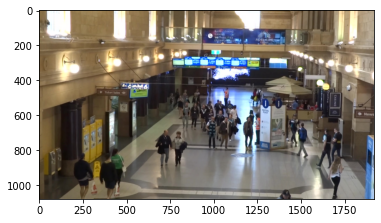

In [11]:
im = Image.open('/content/MOT20Det/train/MOT20-01/img1/000001.jpg')

# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(im)

plt.show()

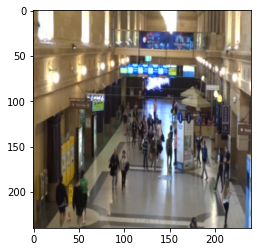

In [12]:
transform = transforms.Compose([
              transforms.Resize((240, 240))\
              # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
          ])
image = transform(im)
plt.imshow(image) 

In [13]:
im = im.resize((240, 240)) #how to resize by PIL

In [14]:
#result.save('out.bmp') #how to save by PIL

resize and show bounding box for resized image


In [15]:
def rescaleCoords(df, oldW, oldH, newW, newH):
  rW = oldW / newW
  rH = oldH / newH
  down = (df['bb_top'] + df['bb_height']) / rH
  right = (df['bb_left'] + df['bb_width']) / rW
  df['bb_top'] = df['bb_top'] / rH
  df['bb_left'] = df['bb_left'] / rW
  df['bb_height'] = down - df['bb_top']
  df['bb_width'] = right - df['bb_left']
  return df

In [16]:
df = pd.read_csv('/content/MOT20Det/train/MOT20-01/gt/gt.txt', names=['frame', 'id', 'bb_left', 'bb_top', 'bb_width', 'bb_height', 'conf', 'class', '_'])
bboxes = df[(df['class']==1)&(df['frame']==1)]

In [17]:
bboxes

,frame,id,bb_left,bb_top,bb_width,bb_height,conf,class,_
0,1,1,199,813,140,268,1,1,0.836430
338,1,2,347,814,124,267,1,1,0.884690
689,1,3,399,789,104,259,1,1,0.337730
1056,1,4,1651,831,100,250,1,1,0.996020
1098,1,5,667,686,97,221,1,1,1.000000
1347,1,6,759,691,93,206,1,1,0.936170
1580,1,7,1583,673,116,242,1,1,0.853500
2009,1,8,1671,669,76,221,1,1,0.461680
2867,1,10,1503,510,52,100,1,1,0.574260
3725,1,12,1472,639,78,211,1,1,0.995280


In [18]:
rescaleCoords(bboxes, imWidth, imHeight, 240, 240)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

,frame,id,bb_left,bb_top,bb_width,bb_height,conf,class,_
0,1,1,24.875,180.666667,17.500,59.555556,1,1,0.836430
338,1,2,43.375,180.888889,15.500,59.333333,1,1,0.884690
689,1,3,49.875,175.333333,13.000,57.555556,1,1,0.337730
1056,1,4,206.375,184.666667,12.500,55.555556,1,1,0.996020
1098,1,5,83.375,152.444444,12.125,49.111111,1,1,1.000000
1347,1,6,94.875,153.555556,11.625,45.777778,1,1,0.936170
1580,1,7,197.875,149.555556,14.500,53.777778,1,1,0.853500
2009,1,8,208.875,148.666667,9.500,49.111111,1,1,0.461680
2867,1,10,187.875,113.333333,6.500,22.222222,1,1,0.574260
3725,1,12,184.000,142.000000,9.750,46.888889,1,1,0.995280


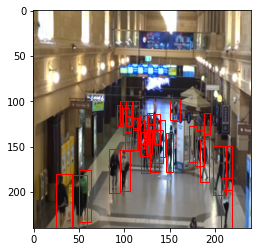

In [19]:
fig, ax = plt.subplots()
ax.imshow(im)
for index, row in bboxes.iterrows():
    rect = patches.Rectangle((row['bb_left'], row['bb_top']), row['bb_width'], row['bb_height'], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
plt.show()

In [20]:
def normalize_sizes(df, w, h):
  df['bb_height'] /= h
  df['bb_width'] /= w
  df['bb_left'] /= w
  df['bb_top'] /= h

In [21]:
def to_files(df, path, frame):
  df = df[['class', 'bb_left', 'bb_top', 'bb_width', 'bb_height']]
  fpath = os.path.join(path, frame+'.txt')
  df.to_csv(fpath, header=False, index=False, float_format='%.6f', sep=" ")

In [46]:
# !rm -rf /content/train

In [ ]:
!cp -r /content/MOT20Det/train .

In [24]:
root = '/content/train'
def create_lbl_dir(current_dir_name):
  local_dir_path = os.path.join(root, current_dir_name)
  label_path = os.path.join(local_dir_path, 'labels')
  if not os.path.isdir(label_path):
    os.mkdir(label_path)
  return label_path

def read_gt(current_dir_name):
  local_dir_path = os.path.join(root, current_dir_name)
  gt_path = os.path.join(local_dir_path, 'gt')
  gt_text_path = os.path.join(gt_path, 'gt.txt')
  return pd.read_csv(gt_text_path, names=['frame', 'id', 'bb_left', 'bb_top', 'bb_width', 'bb_height', 'conf', 'class', '_'])

def read_img_info(current_dir_name):
  local_dir_path = os.path.join(root, current_dir_name)
  ini_path = os.path.join(local_dir_path, 'seqinfo.ini')
  config = configparser.ConfigParser()
  config.read(ini_path)
  return int(config['Sequence']['imWidth']), int(config['Sequence']['imHeight'])

In [25]:
target_height = 208
target_width = 416
for dname in os.listdir(root):
  label_path = create_lbl_dir(dname)
  # if "/content/train/.ipynb_checkpoints" == local_dir_path:
  #   continue
  df = read_gt(dname)
  imWidth, imHeight = read_img_info(dname)
  # df = df[df['class'] == 1]
  df['class'] -= 1
  df['bb_left'] += (df['bb_width'] / 2)
  df['bb_top'] += (df['bb_height'] / 2)
  rescaleCoords(df, imWidth, imHeight, target_width, target_height)

  normalize_sizes(df, target_width, target_height)
  df.frame = df.frame.apply(lambda a: '{:0>6}'.format(int(dname[-1])*100000+a))
  if os.path.isdir(label_path):
    df = df.groupby(df["frame"]).apply(lambda _:to_files(_, label_path, _['frame'].any()))

check labels


In [26]:
lbl = pd.read_csv('/content/train/MOT20-01/labels/100001.txt', sep=" ", names=['class', 'bb_left', 'bb_top', 'bb_width', 'bb_height'])

In [27]:
lbl

,class,bb_left,bb_top,bb_width,bb_height
0,0,0.140104,0.876852,0.072917,0.248148
1,0,0.213021,0.877315,0.064583,0.247222
2,0,0.234896,0.850463,0.054167,0.239815
3,0,0.885938,0.885185,0.052083,0.231481
4,0,0.372656,0.737500,0.050521,0.204630
5,0,0.419531,0.735185,0.048438,0.190741
6,0,0.854688,0.735185,0.060417,0.224074
7,0,0.890104,0.721759,0.039583,0.204630
8,6,0.656771,0.629630,0.030208,0.168519
9,0,0.796354,0.518519,0.027083,0.092593


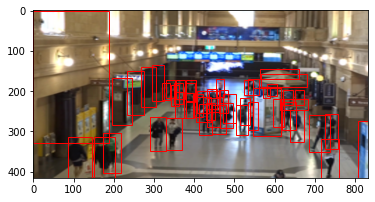

In [28]:
im = im.resize((832, 416))
fig, ax = plt.subplots()
ax.imshow(im)
for index, row in lbl.iterrows():
    rect = patches.Rectangle(((row['bb_left'] - row['bb_width'] / 2)*832, (row['bb_top'] - row['bb_height'] / 2)*416), row['bb_width']*832, row['bb_height']*416, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
plt.show()

In [29]:
# image = Image.open('/content/train/MOT20-01/img1/000001.jpg')
# name = '000001.jpg'
# image = image.resize((target_width, target_height))
# image.save(os.path.join('.', name))

In [30]:
root = '/content/train'
for name in os.listdir(root):
  if ".ipynb_checkpoints" == name:
    continue
  locpath = os.path.join(os.path.join(root, name), 'img1')
  for nroot, _, files in os.walk(locpath, topdown=False):
    for fname in files:
      image = Image.open(os.path.join(nroot, fname))
      foldname = str(fname)
      fname = name[-1] + fname[1:]
      image = image.resize((target_width, target_height))
      image.save(os.path.join(nroot, fname))
      os.remove(os.path.join(nroot, foldname))

In [31]:
!cd train && mkdir images && cd images && mkdir train && mkdir val

In [32]:
!cd train && mkdir labels && cd labels && mkdir train && mkdir val

In [33]:
!cd /content/train/images/train && mkdir train
!cd /content/train/images/val && mkdir train

In [34]:
root = '/content/train'
target_img_train = '/content/train/images/train'
target_img_val = '/content/train/images/val'
target_lbl_train = '/content/train/labels/train'
target_lbl_val = '/content/train/labels/val'
for name_dir in os.listdir(root):
  local_dir_path = os.path.join(root, name_dir)
  img_path = os.path.join(local_dir_path, 'img1')
  labels_path = os.path.join(local_dir_path, 'labels')
  if name_dir == 'MOT20-05':
    for nroot, _, files in os.walk(img_path, topdown=False):
      for name in files:
        shutil.move(os.path.join(nroot, name), target_img_val)

    for nroot, _, files in os.walk(labels_path, topdown=False):
      for name in files:
        shutil.move(os.path.join(nroot, name), target_lbl_val)
    continue
  for nroot, _, files in os.walk(img_path, topdown=False):
    for name in files:
      shutil.move(os.path.join(nroot, name), target_img_train)

  for nroot, _, files in os.walk(labels_path, topdown=False):
    for name in files:
      shutil.move(os.path.join(nroot, name), target_lbl_train)
    
  
  

In [35]:
# root = '/content/train/images/train'
# target_img_train = '/content/train/images/train'
# target_img_val = '/content/train/images/val'
# target_lbl_train = '/content/train/labels/train'
# target_lbl_val = '/content/train/labels/val'
# for nroot, _, files in os.walk(target_img_train, topdown=False):
#   for name in files:
#     if name.startswith('5'):
#       shutil.move(os.path.join(target_img_train, name), os.path.join(target_img_val, name))


# for nroot, _, files in os.walk(target_lbl_train, topdown=False):
#   for name in files:
#     if name.startswith('5'):
#       shutil.move(os.path.join(target_lbl_train, name), os.path.join(target_lbl_val, name))


# Train


In [36]:
!git clone https://github.com/ultralytics/yolov5


Cloning into 'yolov5'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 5126 (delta 4), reused 6 (delta 1), pack-reused 5110
Receiving objects: 100% (5126/5126), 7.99 MiB | 23.56 MiB/s, done.
Resolving deltas: 100% (3486/3486), done.


In [43]:
!cd yolov5 && wget https://raw.githubusercontent.com/denn98987/yolovideo/main/mot.yaml

--2021-03-07 06:09:17--  https://raw.githubusercontent.com/denn98987/yolovideo/main/mot.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 286 [text/plain]
Saving to: ‘mot.yaml’

mot.yaml            100%[===================>]     286  --.-KB/s    in 0s      

2021-03-07 06:09:17 (19.8 MB/s) - ‘mot.yaml’ saved [286/286]



In [38]:
!cd yolov5 && pip install -r requirements.txt 

     |████████████████████████████████| 645kB 8.7MB/s 
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [39]:
# %reload_ext tensorboard


In [40]:
# Tensorboard (optional)
# !cd yolov5/ && reload_ext tensorboard && !tensorboard --logdir runs/train

//key for api below ef9a9fcc2cec66ad480386182cd38a1bb2fb91d3

In [41]:
%pip install -q wandb  
!wandb login 

     |████████████████████████████████| 2.0MB 10.4MB/s 
     |████████████████████████████████| 163kB 51.3MB/s 
     |████████████████████████████████| 102kB 11.5MB/s 
     |████████████████████████████████| 133kB 51.5MB/s 
     |████████████████████████████████| 71kB 11.0MB/s 
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


//get mot.yaml from github


In [45]:
!cd yolov5 && python train.py --img-size 416 --batch 64 --epochs 30 --data mot.yaml --weights yolov5m.pt --nosave --cache-images

github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 v4.0-121-gba18528 torch 1.7.1+cu101 CUDA:0 (Tesla T4, 15109.75MB)

Namespace(adam=False, batch_size=64, bucket='', cache_images=True, cfg='', data='mot.yaml', device='', entity=None, epochs=30, evolve=False, exist_ok=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[416, 416], linear_lr=False, local_rank=-1, log_artifacts=False, log_imgs=16, multi_scale=False, name='exp', noautoanchor=False, nosave=True, notest=False, project='runs/train', quad=False, rect=False, resume=False, save_dir='runs/train/exp2', single_cls=False, sync_bn=False, total_batch_size=64, weights='yolov5m.pt', workers=8, world_size=1)
Start Tensorboard with "tensorboard --logdir runs/train", view at http://localhost:6006/
2021-03-07 06:17:05.009474: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
hyperparameters: lr0=0.01, lrf=0.2, momentum=0.937